# RL Flappy Bird Assignment

Environment import and setup

In [1]:
import gymnasium as gym
import matplotlib.pyplot as plt

import text_flappy_bird_gym

from tqdm import tqdm
import numpy as np

In [2]:
# Global variables for the evaluation
max_steps_for_evaluation = 1000
num_episodes_for_evaluation = 2000

## Reference agent: Random agent

In [3]:
def play_random_episode(env):
    env.reset()
    done = False
    total_reward = 0
    for  _ in range(max_steps_for_evaluation):
        action = env.action_space.sample()
        _, reward, done, _, _ = env.step(action)
        total_reward += reward
        if done:
            break
    return total_reward

def evaluate_random_policy(env):
    total_rewards = []
    for _ in tqdm(range(num_episodes_for_evaluation)):
        total_reward = play_random_episode(env)
        total_rewards.append(total_reward)
    return total_rewards

100%|██████████| 2000/2000 [00:00<00:00, 6357.59it/s]


Mean total reward 11.3105
Std total reward 5.753180837588889
Max total reward 35
Min total reward 4
Quartiles [ 7. 12. 13.]


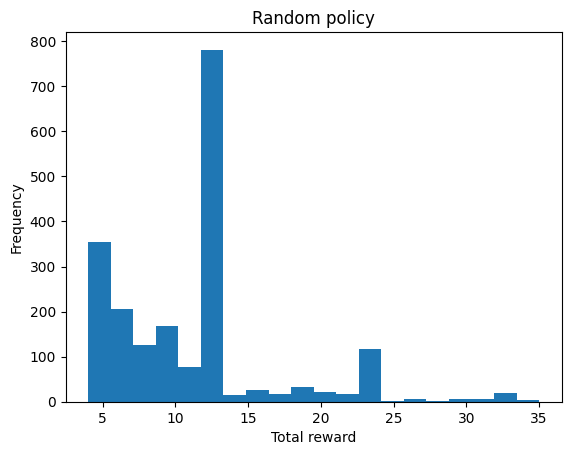

In [4]:
total_rewards = evaluate_random_policy(gym.make('TextFlappyBird-v0'))
print('Mean total reward', np.mean(total_rewards))
print('Std total reward', np.std(total_rewards))
print('Max total reward', np.max(total_rewards))
print('Min total reward', np.min(total_rewards))
print('Quartiles', np.percentile(total_rewards, [25, 50, 75]))
plt.hist(total_rewards, bins=20)
plt.xlabel('Total reward')
plt.ylabel('Frequency')
plt.title('Random policy')
plt.show()

## First agent: Sarsa ($\lambda$)

In [3]:
from src.agents import SarsaLambdaAgent
from src.exploration_policy import EpsilonGreedy
from src.utils.data_structures import Transition, SarsaLambdaParams

def train_sarsa_lambda(params, epsilon, num_episodes, max_train_steps):
    env = gym.make('TextFlappyBird-v0')
    agent = SarsaLambdaAgent(params, EpsilonGreedy(epsilon))
    
    rewards = np.zeros(num_episodes)
    for episode in tqdm(range(num_episodes)):
        state, _ = env.reset()
        action = agent.act(state)
        total_reward = 0
        for _ in range(max_train_steps):
            next_state, reward, done, _, _ = env.step(action)
            next_action = agent.act(next_state)
            transition = Transition(state, action, reward, next_state, done)
            agent.update(transition, next_action)
            total_reward += reward
            if done:
                break
            state = next_state
            action = next_action
        rewards[episode] = total_reward
    return agent, rewards

def play_sarsa_lambda_episode(env, agent):
    state, _ = env.reset()
    done = False
    total_reward = 0
    for  _ in range(max_steps_for_evaluation):
        action = agent.get_best_action(state)
        next_state, reward, done, _, _ = env.step(action)
        total_reward += reward
        if done:
            break
        state = next_state
    return total_reward

def evaluate_sarsa_lambda(env, agent):
    total_rewards = []
    for _ in tqdm(range(num_episodes_for_evaluation)):
        total_reward = play_sarsa_lambda_episode(env, agent)
        total_rewards.append(total_reward)
    return total_rewards

100%|██████████| 2000/2000 [00:21<00:00, 91.81it/s] 


Mean total reward 639.285
Std total reward 353.631784169636
Max total reward 1000
Min total reward 29
Quartiles [ 299.  699. 1000.]


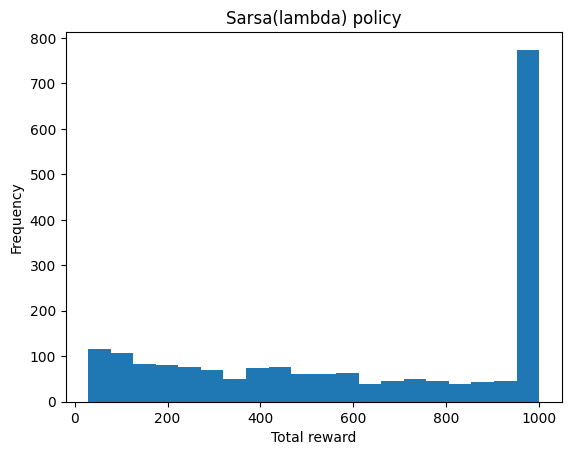

In [7]:
params = SarsaLambdaParams(alpha=0.05, gamma=0.99, num_actions=2, lambd=0.9)
agent, rewards = train_sarsa_lambda(params, epsilon=0.1, num_episodes=10000, max_train_steps=1000)
total_rewards = evaluate_sarsa_lambda(gym.make('TextFlappyBird-v0'), agent)
print('Mean total reward', np.mean(total_rewards))
print('Std total reward', np.std(total_rewards))
print('Max total reward', np.max(total_rewards))
print('Min total reward', np.min(total_rewards))
print('Quartiles', np.percentile(total_rewards, [25, 50, 75]))
plt.hist(total_rewards, bins=20)
plt.xlabel('Total reward')
plt.ylabel('Frequency')
plt.title('Sarsa(lambda) policy')
plt.show()

## Second agent: Off-policy Monte Carlo control

In [4]:
from src.agents import OffPolicyMonteCarloAgent
from src.utils.data_structures import MonteCarloParams

def train_off_policy_monte_carlo(params, num_episodes, max_train_steps):
    env = gym.make('TextFlappyBird-v0')
    agent = OffPolicyMonteCarloAgent(params)
    
    rewards = np.zeros(num_episodes)
    for episode in tqdm(range(num_episodes)):
        state, _ = env.reset()
        total_reward = 0
        episode_transitions = []
        for _ in range(max_train_steps):
            action = agent.act(state)
            next_state, reward, done, _, _ = env.step(action)
            episode_transitions.append((state, action, reward))
            total_reward += reward
            if done:
                break
            state = next_state
        agent.update(episode_transitions)
        rewards[episode] = total_reward
    return agent, rewards

def play_off_policy_monte_carlo_episode(env, agent):
    state, _ = env.reset()
    done = False
    total_reward = 0
    for  _ in range(max_steps_for_evaluation):
        action = agent.get_best_action(state)
        next_state, reward, done, _, _ = env.step(action)
        total_reward += reward
        if done:
            break
        state = next_state
    return total_reward

def evaluate_off_policy_monte_carlo(env, agent):
    total_rewards = []
    for _ in tqdm(range(num_episodes_for_evaluation)):
        total_reward = play_off_policy_monte_carlo_episode(env, agent)
        total_rewards.append(total_reward)
    return total_rewards

100%|██████████| 2000/2000 [00:15<00:00, 131.37it/s]


Mean total reward 617.4325
Std total reward 351.891311975374
Max total reward 1000
Min total reward 33
Quartiles [ 283.  643. 1000.]


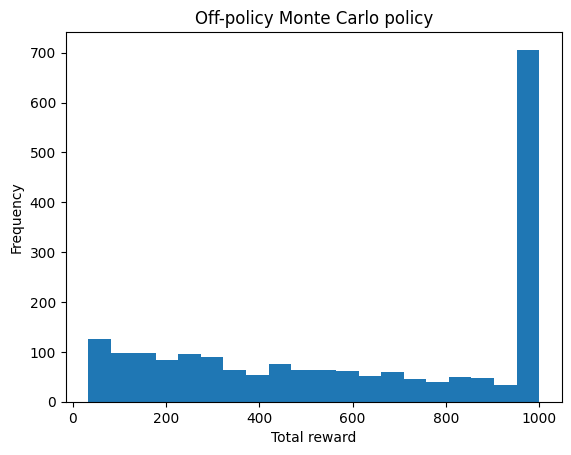

In [17]:
params = MonteCarloParams(num_actions=2, gamma=0.9, epsilon=0.1)
agent, rewards = train_off_policy_monte_carlo(params, num_episodes=10000, max_train_steps=200)
total_rewards = evaluate_off_policy_monte_carlo(gym.make('TextFlappyBird-v0'), agent)
print('Mean total reward', np.mean(total_rewards))
print('Std total reward', np.std(total_rewards))
print('Max total reward', np.max(total_rewards))
print('Min total reward', np.min(total_rewards))
print('Quartiles', np.percentile(total_rewards, [25, 50, 75]))
plt.hist(total_rewards, bins=20)
plt.xlabel('Total reward')
plt.ylabel('Frequency')
plt.title('Off-policy Monte Carlo policy')
plt.show()

## Additional agent: Q-learning

In [5]:
from src.agents import QLearningAgent
from src.utils.data_structures import QLearningParams

def train_q_learning(params, epsilon, num_episodes, max_train_steps):
    env = gym.make('TextFlappyBird-v0')
    agent = QLearningAgent(params, EpsilonGreedy(epsilon))
    
    rewards = np.zeros(num_episodes)
    for episode in tqdm(range(num_episodes)):
        state, _ = env.reset()
        total_reward = 0
        for _ in range(max_train_steps):
            action = agent.act(state)
            next_state, reward, done, _, _ = env.step(action)
            transition = Transition(state, action, reward, next_state, done)
            agent.update(transition)
            total_reward += reward
            if done:
                break
            state = next_state
        rewards[episode] = total_reward
    return agent, rewards

def play_q_learning_episode(env, agent):
    state, _ = env.reset()
    done = False
    total_reward = 0
    for  _ in range(max_steps_for_evaluation):
        action = agent.get_best_action(state)
        next_state, reward, done, _, _ = env.step(action)
        total_reward += reward
        if done:
            break
        state = next_state
    return total_reward

def evaluate_q_learning(env, agent):
    total_rewards = []
    for _ in tqdm(range(num_episodes_for_evaluation)):
        total_reward = play_q_learning_episode(env, agent)
        total_rewards.append(total_reward)
    return total_rewards

100%|██████████| 2000/2000 [00:22<00:00, 87.94it/s]


Mean total reward 956.428
Std total reward 163.78163760324293
Max total reward 1000
Min total reward 28
Quartiles [1000. 1000. 1000.]


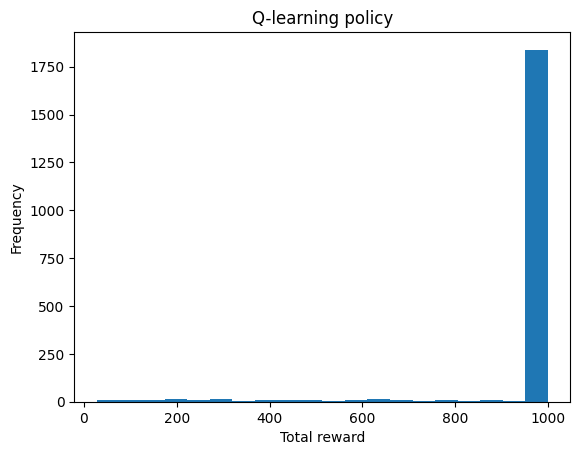

In [10]:
params = QLearningParams(alpha=0.05, gamma=0.9, num_actions=2)
agent, rewards = train_q_learning(params, epsilon=0.1, num_episodes=50000, max_train_steps=1000)
total_rewards = evaluate_q_learning(gym.make('TextFlappyBird-v0'), agent)
print('Mean total reward', np.mean(total_rewards))
print('Std total reward', np.std(total_rewards))
print('Max total reward', np.max(total_rewards))
print('Min total reward', np.min(total_rewards))
print('Quartiles', np.percentile(total_rewards, [25, 50, 75]))
plt.hist(total_rewards, bins=20)
plt.xlabel('Total reward')
plt.ylabel('Frequency')
plt.title('Q-learning policy')
plt.show()

## Additional agent: Sarsa

In [6]:
from src.agents import SarsaAgent
from src.utils.data_structures import SarsaParams

def train_sarsa(params, epsilon, num_episodes, max_train_steps):
    env = gym.make('TextFlappyBird-v0')
    agent = SarsaAgent(params, EpsilonGreedy(epsilon))
    
    rewards = np.zeros(num_episodes)
    for episode in tqdm(range(num_episodes)):
        state, _ = env.reset()
        action = agent.act(state)
        total_reward = 0
        for _ in range(max_train_steps):
            next_state, reward, done, _, _ = env.step(action)
            next_action = agent.act(next_state)
            transition = Transition(state, action, reward, next_state, done)
            agent.update(transition, next_action)
            total_reward += reward
            if done:
                break
            state = next_state
            action = next_action
        rewards[episode] = total_reward
    return agent, rewards

def play_sarsa_episode(env, agent):
    state, _ = env.reset()
    done = False
    total_reward = 0
    for  _ in range(max_steps_for_evaluation):
        action = agent.get_best_action(state)
        next_state, reward, done, _, _ = env.step(action)
        total_reward += reward
        if done:
            break
        state = next_state
    return total_reward

def evaluate_sarsa(env, agent):
    total_rewards = []
    for _ in tqdm(range(num_episodes_for_evaluation)):
        total_reward = play_sarsa_episode(env, agent)
        total_rewards.append(total_reward)
    return total_rewards

  0%|          | 0/50000 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [00:24<00:00, 80.01it/s]


Mean total reward 1000.0
Std total reward 0.0
Max total reward 1000
Min total reward 1000
Quartiles [1000. 1000. 1000.]


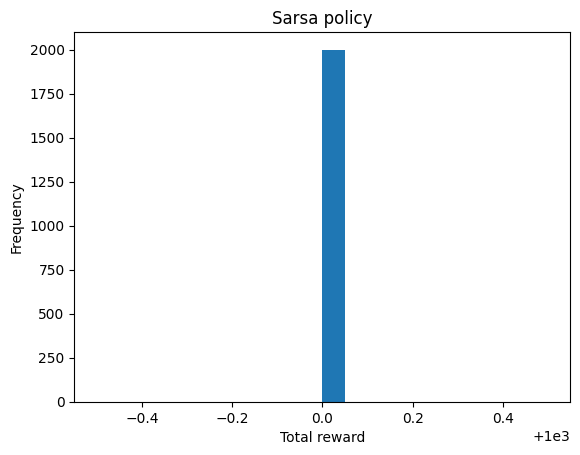

In [7]:
params = SarsaParams(alpha=0.05, gamma=0.9, num_actions=2)
agent, rewards = train_sarsa(params, epsilon=0.1, num_episodes=50000, max_train_steps=1000)
total_rewards = evaluate_sarsa(gym.make('TextFlappyBird-v0'), agent)
print('Mean total reward', np.mean(total_rewards))
print('Std total reward', np.std(total_rewards))
print('Max total reward', np.max(total_rewards))
print('Min total reward', np.min(total_rewards))
print('Quartiles', np.percentile(total_rewards, [25, 50, 75]))
plt.hist(total_rewards, bins=20)
plt.xlabel('Total reward')
plt.ylabel('Frequency')
plt.title('Sarsa policy')
plt.show()